In [230]:
import pandas as pd
import numpy as np

from scipy import stats

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
# Load Data from https://www.kaggle.com/datasets/sapere0/bitcoinheist-ransomware-dataset/download?datasetVersionNumber=1
df=pd.read_csv('Downloads/BitcoinHeistData.csv')

In [206]:
print(df.head())

                              address  year  day  length    weight  count  \
0   111K8kZAEnJg245r2cM6y9zgJGHZtJPy6  2017   11      18  0.008333      1   
1  1123pJv8jzeFQaCV4w644pzQJzVWay2zcA  2016  132      44  0.000244      1   
2  112536im7hy6wtKbpH1qYDWtTyMRAcA2p7  2016  246       0  1.000000      1   
3  1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7  2016  322      72  0.003906      1   
4  1129TSjKtx65E35GiUo4AYVeyo48twbrGX  2016  238     144  0.072848    456   

   looped  neighbors       income            label  
0       0          2  100050000.0  princetonCerber  
1       0          1  100000000.0   princetonLocky  
2       0          2  200000000.0  princetonCerber  
3       0          2   71200000.0  princetonCerber  
4       0          1  200000000.0   princetonLocky  


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [208]:
df.query('label!="white"').groupby('year')['label'].value_counts()

year  label                      
2011  montrealCryptoLocker             65
2012  montrealCryptoLocker            714
2013  montrealCryptoLocker           7484
      montrealRazy                      8
      montrealNoobCrypt                 2
2014  paduaCryptoWall                9157
      montrealCryptoLocker           1050
      montrealNoobCrypt               109
      montrealGlobeImposter             2
      montrealCryptoTorLocker2015       1
2015  paduaCryptoWall                3233
      montrealNoobCrypt               300
      montrealDMALocker                73
      montrealCryptoTorLocker2015      53
      montrealGlobeImposter            38
      montrealCryptoLocker              2
      montrealRazy                      2
2016  princetonLocky                 6585
      princetonCerber                6043
      montrealCryptXXX               2419
      montrealDMALockerv3             193
      montrealDMALocker               178
      montrealNoobCrypt                72


In [209]:
# select only years with > 1k instances of ransomware to reduce data size
df=df.query('year > 2012 and year < 2018')
df['year'].value_counts()

2016    380631
2014    375319
2013    372494
2015    368701
2017    368486
Name: year, dtype: int64

In [210]:
df['label'].value_counts()

white                          1825000
paduaCryptoWall                  12390
princetonCerber                   9223
montrealCryptoLocker              8536
princetonLocky                    6625
montrealCryptXXX                  2419
montrealNoobCrypt                  483
montrealDMALockerv3                354
montrealDMALocker                  251
montrealSamSam                      62
montrealCryptoTorLocker2015         55
montrealGlobeImposter               55
montrealGlobev3                     34
montrealGlobe                       32
montrealWannaCry                    28
montrealRazy                        12
montrealAPT                         11
paduaKeRanger                       10
montrealXTPLocker                    8
montrealXLockerv5.0                  7
montrealVenusLocker                  7
montrealCryptConsole                 7
montrealFlyper                       7
montrealEDA2                         6
montrealJigSaw                       4
paduaJigsaw              

In [211]:
# Drop columns not used for regression
df.drop(columns=["address","year","day"],axis=1,inplace=True)

In [212]:
df.head()

,length,weight,count,looped,neighbors,income,label
0,18,0.008333,1,0,2,100050000.0,princetonCerber
1,44,0.000244,1,0,1,100000000.0,princetonLocky
2,0,1.000000,1,0,2,200000000.0,princetonCerber
3,72,0.003906,1,0,2,71200000.0,princetonCerber
4,144,0.072848,456,0,1,200000000.0,princetonLocky


In [213]:
# create numerical classifications for White, Princeton, Padua and montreal
%time
def prince(row):
    if 'princeton' in row['label']:
        val= 1
    else:
        val = 0
    return val

df['princeton'] = df.apply(prince, axis=1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [214]:
%time
def padua(row):
    if 'padua' in row['label']:
        val= 1
    else:
        val = 0
    return val

df['padua'] = df.apply(padua, axis=1)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [215]:
%time
def montreal(row):
    if 'montreal' in row['label']:
        val= 1
    else:
        val = 0
    return val

df['montreal'] = df.apply(montreal, axis=1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [216]:
%time
def white(row):
    if 'white' in row['label']:
        val= 1
    else:
        val = 0
    return val

df['white'] = df.apply(white, axis=1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [217]:
# manual over sampling
df_white=df.query('label == "white"')
print(df_white['label'].value_counts())

df_rwr=df.query('label != "white"')
df_rwr['label'].value_counts()

white    1825000
Name: label, dtype: int64


paduaCryptoWall                12390
princetonCerber                 9223
montrealCryptoLocker            8536
princetonLocky                  6625
montrealCryptXXX                2419
montrealNoobCrypt                483
montrealDMALockerv3              354
montrealDMALocker                251
montrealSamSam                    62
montrealCryptoTorLocker2015       55
montrealGlobeImposter             55
montrealGlobev3                   34
montrealGlobe                     32
montrealWannaCry                  28
montrealRazy                      12
montrealAPT                       11
paduaKeRanger                     10
montrealXTPLocker                  8
montrealVenusLocker                7
montrealXLockerv5.0                7
montrealCryptConsole               7
montrealFlyper                     7
montrealEDA2                       6
montrealJigSaw                     4
paduaJigsaw                        2
montrealXLocker                    1
montrealSam                        1
m

In [218]:
# Randomly undersample by combining entire positive dataset with 2% of negative dataset
df_under_sample=df_white.sample(frac=.03,random_state=42).append(df_rwr)

/var/folders/nc/d0qq985n7zv3k6s5tl41yz4c0000gn/T/ipykernel_16488/3515397921.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_under_sample=df_white.sample(frac=.03,random_state=42).append(df_rwr)


In [220]:
df_under_sample.head()

,length,weight,count,looped,neighbors,income,label,princeton,padua,montreal,white
2296118,42,3.051758e-05,1,0,2,3.859276e+08,white,0,0,0,1
873068,2,2.500000e-01,1,0,2,1.469950e+09,white,0,0,0,1
1566324,144,2.369196e-01,1028,1,2,2.424425e+08,white,0,0,0,1
2464558,12,3.478261e-07,1,0,1,4.280000e+07,white,0,0,0,1
2044142,6,5.000000e-01,1,0,2,4.440000e+07,white,0,0,0,1


<AxesSubplot:xlabel='white', ylabel='Count'>

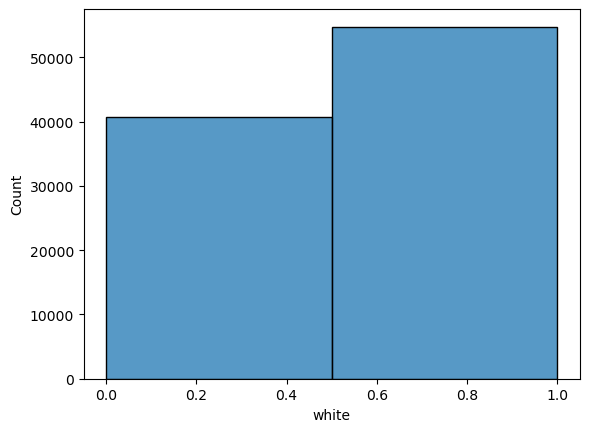

In [221]:
# 30:70 distribution to provide negative ample data for learning
# and reasonable amount of negative data points for regression 
sns.histplot(df_under_sample['white'],bins=2)

In [222]:
df_under_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95381 entries, 2296118 to 41412
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   length     95381 non-null  int64  
 1   weight     95381 non-null  float64
 2   count      95381 non-null  int64  
 3   looped     95381 non-null  int64  
 4   neighbors  95381 non-null  int64  
 5   income     95381 non-null  float64
 6   label      95381 non-null  object 
 7   princeton  95381 non-null  int64  
 8   padua      95381 non-null  int64  
 9   montreal   95381 non-null  int64  
 10  white      95381 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 8.7+ MB


In [224]:
# create training set for manual over sampling
X_under=df_under_sample.drop(['white','label','montreal','princeton','padua'],axis=1)
y_under=df_under_sample['white']
X_train_man, X_test_man, y_train_man, y_test_man = train_test_split(X_under, y_under, test_size=0.33, random_state=42)

In [225]:
y_under.value_counts()

1    54750
0    40631
Name: white, dtype: int64

In [227]:
#Use smote to resample and create smote training sets categorizing White Label
X_resample=df.drop(['white','label','montreal','princeton','padua'],axis=1)
y_resample=df['white']
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_resample(X_resample_train,y_resample_train)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_train_smote, y_train_smote, test_size=0.33, random_state=42)

In [228]:
# Use Near Miss to resample and create near miss (nm) training sets categorizing White Label
nm = NearMiss()
X_train_nm, y_train_nm = nm.fit_resample(X_resample_train, y_resample_train)
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X_train_nm, y_train_nm, test_size=0.33, random_state=42)

In [229]:
print("under \n",y_train_under.value_counts())
print('smote \n',y_train_smote.value_counts())
print('nm \n',y_train_nm.value_counts())


under 
 1    36623
0    27282
Name: white, dtype: int64
smote 
 1    819482
0    819070
Name: white, dtype: int64
nm 
 1    18234
0    18176
Name: white, dtype: int64


In [231]:
pipe_under_knn=Pipeline([('scale',StandardScaler()),('knn',KNeighborsClassifier())]).fit(X_train_under,y_train_under)

In [232]:
pipe_smote_knn=Pipeline([('scale',StandardScaler()),('knn',KNeighborsClassifier())]).fit(X_train_smote,y_train_smote)

In [233]:
pipe_nm_knn=Pipeline([('scale',StandardScaler()),('knn',KNeighborsClassifier())]).fit(X_train_nm,y_train_nm)

In [234]:
pipe_under_lr=Pipeline([('scale',StandardScaler()),('lr',LogisticRegression())]).fit(X_train_under,y_train_under)

In [235]:
pipe_smote_lr=Pipeline([('scale',StandardScaler()),('lr',LogisticRegression())]).fit(X_train_smote,y_train_smote)

In [236]:
pipe_nm_lr=Pipeline([('scale',StandardScaler()),('lr',LogisticRegression(n_estimators = 100))]).fit(X_train_nm,y_train_nm)

In [237]:
pipe_under_rf=Pipeline([('scale',StandardScaler()),('rf',RandomForestClassifier(n_jobs = 4))]).fit(X_train_under,y_train_under)

In [241]:
pipe_smote_rf=Pipeline([('scale',StandardScaler()),('rf',RandomForestClassifier(n_jobs=4))]).fit(X_train_smote,y_train_smote)

In [242]:
pipe_nm_rf=Pipeline([('scale',StandardScaler()),('rf',RandomForestClassifier(n_jobs=4))]).fit(X_train_nm,y_train_nm)

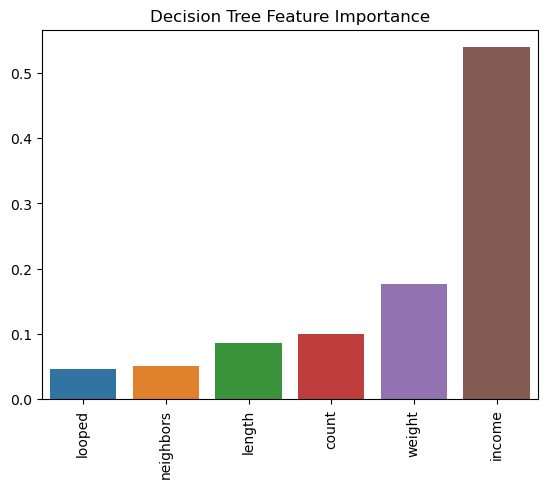

In [243]:
df_rf_features=pd.DataFrame(columns=pipe_under_rf.named_steps.scale.get_feature_names_out())
df_rf_features.loc[len(df_rf_features)] = pipe_under_rf.named_steps.rf.feature_importances_
df_rf_features=df_rf_features.sort_values(by=0, ascending=True, axis=1)
df_rf_features.head()
sns.barplot(data=df_rf_features).set(title='Decision Tree Feature Importance')
plt.xticks(rotation=90);

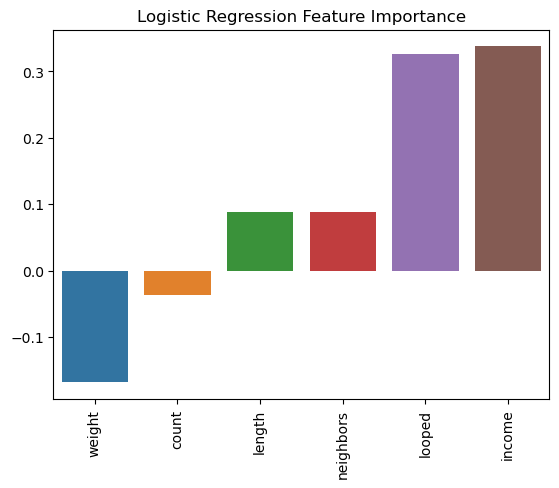

In [244]:
df_lr_features=pd.DataFrame(pipe_under_lr.named_steps.lr.coef_,columns=pipe_under_lr.named_steps.scale.get_feature_names_out())
df_lr_features=df_lr_features.sort_values(by=0, ascending=True, axis=1)
df_lr_features.head()
sns.barplot(data=df_lr_features).set(title='Logistic Regression Feature Importance')
plt.xticks(rotation=90);

In [247]:
df_features=df_rf_features.append(df_lr_features)
df_features.reset_index(inplace=True)
df_features=df_features.rename(columns={'index':'model'})
df_features['model'].iloc[0]='random forest'
df_features['model'].iloc[1]='logistic regression'
df_features.head()

/var/folders/nc/d0qq985n7zv3k6s5tl41yz4c0000gn/T/ipykernel_16488/3594014974.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features=df_rf_features.append(df_lr_features)
/var/folders/nc/d0qq985n7zv3k6s5tl41yz4c0000gn/T/ipykernel_16488/3594014974.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['model'].iloc[0]='random forest'


,model,looped,neighbors,length,count,weight,income
0,random forest,0.046008,0.051498,0.085857,0.100580,0.176683,0.539373
1,logistic regression,0.325608,0.088729,0.087807,-0.036478,-0.168759,0.337678


In [256]:
#scale test data sets
scale=StandardScaler()

# scale under sample dataset
scale.fit(X_train_under)
X_test_man_scaled=scale.transform(X_test_man)

# scale smote data set
scale.fit(X_train_smote)
X_test_smote_scaled=scale.transform(X_test_smote)

# scale near miss data set
scale.fit(X_train_nm)
X_test_nm_scaled=scale.transform(X_test_nm)

In [257]:
preds_knn_man=pipe_under_knn.named_steps.knn.predict(X_test_man_scaled)
preds_knn_smote=pipe_smote_knn.named_steps.knn.predict(X_test_smote_scaled)
preds_knn_nm=pipe_nm_knn.named_steps.knn.predict(X_test_nm_scaled)
print('knn complete')
preds_lr_man=pipe_under_lr.named_steps.lr.predict(X_test_man_scaled)
preds_lr_smote=pipe_smote_lr.named_steps.lr.predict(X_test_smote_scaled)
preds_lr_nm=pipe_nm_lr.named_steps.lr.predict(X_test_nm_scaled)
print('lr complete')
preds_rf_man=pipe_under_rf.named_steps.rf.predict(X_test_man_scaled)
preds_rf_smote=pipe_smote_rf.named_steps.rf.predict(X_test_smote_scaled)
preds_rf_nm=pipe_nm_rf.named_steps.rf.predict(X_test_nm_scaled)
print('rf complete')




/Users/joshuagreenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joshuagreenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

knn complete
lr complete
rf complete


In [258]:
print(len(y_test_smote))
print(len(preds_knn_smote))

807048
807048


In [259]:
print("Under KNN Pscore: ",precision_score(y_test_man,preds_knn_man))
print("Smote KNN Pscore: ", precision_score(y_test_smote,preds_knn_smote))
print("Near Miss KNN Pscore: ", precision_score(y_test_nm,preds_knn_nm,zero_division=1))

print("Under logistic regression Pscore: ",precision_score(y_test_man,preds_lr_man))
print("Smote logistic regression Pscore: ", precision_score(y_test_smote,preds_lr_smote))
print("Near Miss logistic regression Pscore: ", precision_score(y_test_nm,preds_lr_nm,zero_division=1))

print("Under RandomForest Pscore: ",precision_score(y_test_man,preds_rf_man))
print("Smote RandomForest Pscore: ", precision_score(y_test_smote,preds_rf_smote))
print("Near Miss RandomForest Pscore: ", precision_score(y_test_nm,preds_rf_nm))


Under KNN Pscore:  0.722957629465522
Smote KNN Pscore:  0.8928485085413591
Near Miss KNN Pscore:  0.8402543214782436
Under logistic regression Pscore:  0.5761379971250599
Smote logistic regression Pscore:  0.6157360632656125
Near Miss logistic regression Pscore:  0.7105781584582441
Under RandomForest Pscore:  0.7752012157370406
Smote RandomForest Pscore:  0.961967888619502
Near Miss RandomForest Pscore:  0.8631578947368421


In [263]:
print("Manual KNN Pscore: ",classification_report(y_test_man,preds_knn_man,zero_division=1))
print("Smote KNN Pscore: ", classification_report(y_test_smote,preds_knn_smote,zero_division=1))
print("Near Miss KNN Pscore: ", classification_report(y_test_nm,preds_knn_nm,zero_division=1))

print("Manual logistic regression Pscore: ",classification_report(y_test_man,preds_lr_man,zero_division=1))
print("Smote logistic regression Pscore: ", classification_report(y_test_smote,preds_lr_smote,zero_division=1))
print("Near Miss logistic regression Pscore: ", classification_report(y_test_nm,preds_lr_nm,zero_division=1))

print("Manual RandromForest Pscore: ",classification_report(y_test_man,preds_rf_man,zero_division=1))
print("Smote RandromForest Pscore: ", classification_report(y_test_smote,preds_rf_smote,zero_division=1))
print("Near Miss RandromForest Pscore: ", classification_report(y_test_nm,preds_rf_nm,zero_division=1))


Manual KNN Pscore:                precision    recall  f1-score   support

           0       0.62      0.63      0.62     13349
           1       0.72      0.72      0.72     18127

    accuracy                           0.68     31476
   macro avg       0.67      0.67      0.67     31476
weighted avg       0.68      0.68      0.68     31476

Smote KNN Pscore:                precision    recall  f1-score   support

           0       0.87      0.90      0.88    403730
           1       0.89      0.86      0.88    403318

    accuracy                           0.88    807048
   macro avg       0.88      0.88      0.88    807048
weighted avg       0.88      0.88      0.88    807048

Near Miss KNN Pscore:                precision    recall  f1-score   support

           0       0.94      0.82      0.88      8996
           1       0.84      0.95      0.89      8938

    accuracy                           0.88     17934
   macro avg       0.89      0.88      0.88     17934
weighted avg